In [1]:
!pip --quiet install gdown pycocotools

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2 
import time
import matplotlib.pyplot as plt
import pandas as pd
import os
import gdown
import random
from IPython.display import display
import imgaug as ia
from imgaug import augmenters as iaa
import imageio
import warnings
import gc
warnings.filterwarnings('ignore')

ft_ntbk = time.time()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### TACO 
the TACO dataset paper used Mask R-CNN architechture --> Pixel-wise segmentation (through classification)

In [ ]:
df_sample['img_file']

image-ID:  16


,img_id,img_width,img_height,img_file,cat_id,cat_name,supercategory,ann_id,x,y,width,height,area
0,0,1537,2049,batch_1/000006.jpg,6,Glass bottle,Bottle,1,517.0,127.0,447.0,1322.0,403954.0
1,1,1537,2049,batch_1/000008.jpg,18,Meal carton,Carton,2,1.0,457.0,1429.0,1519.0,1071259.5
2,1,1537,2049,batch_1/000008.jpg,14,Other carton,Carton,3,531.0,292.0,1006.0,672.0,99583.5


,img_id,img_width,img_height,img_file,cat_id,cat_name,supercategory,ann_id,x,y,width,height,area
49,16,1537,2049,batch_1/000060.jpg,11,Aerosol,Can,50,750.0,244.0,402.0,1467.0,518154.0
50,16,1537,2049,batch_1/000060.jpg,33,Normal paper,Paper,51,1205.0,989.0,332.0,602.0,171665.5


750 244 402 1467
(512, 512, 3)


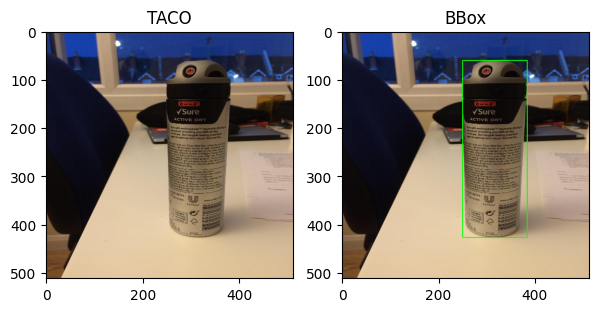

In [3]:
sample_dir = r"/kaggle/input/tacotrashdataset/data"
rn = random.randint(0, len(os.listdir(sample_dir)))
# rn = 6
print('image-ID: ', rn)

df_all_sample = pd.read_csv(r"/kaggle/input/tacotrashdataset/meta_df.csv")
display(df_all_sample.head(3))

df_sample = df_all_sample[df_all_sample['img_id'] == rn]
display(df_sample)

img_path = os.path.join(sample_dir, df_sample['img_file'].tolist()[0])
sample_img = cv2.imread(img_path)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_RGB2BGR)
annot_img = sample_img.copy()
x, y, w, h = int(df_sample['x'].tolist()[0]), int(df_sample['y'].tolist()[0]), int(df_sample['width'].tolist()[0]), int(df_sample['height'].tolist()[0])
print(x, y, w, h)
cv2.rectangle(annot_img, (x, y), (x + w, y + h), (0, 255, 0), 5)

annot_img = cv2.resize(annot_img, (512, 512))
sample_img = cv2.resize(sample_img, (512, 512))

print(sample_img.shape)

fig, axs = plt.subplots(1, 2 ,figsize = (7, 7))

axs[0].imshow(sample_img)
axs[0].set_title('TACO')

axs[1].imshow(annot_img)
axs[1].set_title('BBox')

plt.show()

In [6]:
from pycocotools import mask as maskUtils
import json

image_id = random.randint(0, len(annot_json['images']))
# image_id = 7

df_sample = df_all_sample[df_all_sample['img_id'] == image_id]
display(df_sample)

img_path = os.path.join(sample_dir, df_sample['img_file'].tolist()[0])
sample_img = cv2.imread(img_path)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_RGB2BGR)
sample_img = cv2.resize(sample_img, (512, 512))

plt.imshow(sample_img)
plt.title("Image_ID: " + str(image_id))
plt.show()

with open('/kaggle/input/tacotrashdataset/data/annotations.json', 'rb') as f:
    annot = f.read()
f.close()

print('No. of images: ', len(annot_json['images']))
print()

img_width, img_height =  df_all_sample[df_all_sample['img_id'] == image_id]['img_width'].tolist()[0], df_all_sample[df_all_sample['img_id'] == image_id]['img_height'].tolist()[0]
print('image_id: ', image_id, ', image_w: ', img_width, ', image_h: ', img_height)
print()
print(annot_json.keys())
print()
annot_json = json.loads(annot)
selected_annot = [d for d in annot_json['annotations'] if d['image_id'] == image_id]

print(selected_annot)
print()


def seg_visx(sample_img, annot_list, image_id, height, width, alpha = 0.55, beta = 0.45):
     
    mask_list = []
    
    for i, annot in enumerate(annot_list):
        
        segm = annot['segmentation']
        print('Image_ID: ', annot['image_id'])
        
        if isinstance(segm, list):
            
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)        
        elif isinstance(segm['counts'], list):
            
            rle = maskUtils.frPyObjects(segm, height, width)      
        else:
            
            rle = annot['segmentation']
            
        mask = maskUtils.decode(rle)
        mask = cv2.resize(mask, (512, 512))
#         color_mask = np.zeros_like(sample_img)
    
        if i == 0:      
            color_mask = np.zeros_like(sample_img)
            bin_mask = mask
            
        else:
            bin_mask[mask == 1] = 1
            
        color_mask[bin_mask == 1] = (0, 255, 0)  # Green color with alpha=100 (adjust as needed)
        mask_list.append(mask)
        
    color_mask_img = cv2.addWeighted(sample_img, alpha, color_mask, beta, 0)  # Blend with mask1
    
    return mask_list, bin_mask, color_mask_img

# height, width = 512, 512
_, bin_mask, color_mask_img = seg_visx(sample_img, selected_annot, image_id, img_height, img_width)

fig, axs = plt.subplots(1, 2, figsize = (7, 7))

axs[0].imshow(bin_mask, cmap = 'gray')
axs[0].set_title('Seg-Mask')

axs[1].imshow(color_mask_img)
axs[1].set_title('Masked-Img')

plt.show()

### India-Specific | IndoSet
We aim to perform Binary Instance pixel-wise classification into Liftables (plastic Bag, Paper etc) and Removables (Gutka Stains, Pan Masala etc.) 

https://drive.google.com/file/d/1e3cwXtLE8FpCCO_svfSV6YgLeqS6jTUV/view?usp=drive_link

In [4]:
india_data_path = r"/kaggle/input/data-india-v1/data.txt"
with open(india_data_path, 'r') as f:
    file_id = f.read()[3:].split('/')[-2]
    
print('File-ID: ', file_id)

ft = time.time()

ouput_path = "/kaggle/working/india-data.zip"

file_link = r"https://drive.google.com/uc?id=" + file_id
gdown.download(file_link, quiet=False, output = ouput_path)
!unzip -q "/kaggle/working/india-data.zip"

lt = time.time()
print('time-taken: ', (lt - ft) / 60, ' mins')

File-ID:  1e3cwXtLE8FpCCO_svfSV6YgLeqS6jTUV


Downloading...
From (original): https://drive.google.com/uc?id=1e3cwXtLE8FpCCO_svfSV6YgLeqS6jTUV
From (redirected): https://drive.google.com/uc?id=1e3cwXtLE8FpCCO_svfSV6YgLeqS6jTUV&confirm=t&uuid=fa2c3bc8-7182-473a-91d8-ac7e8685aca0
To: /kaggle/working/india-data.zip
100%|██████████| 1.30G/1.30G [00:22<00:00, 58.8MB/s]


time-taken:  0.5704546372095743  mins


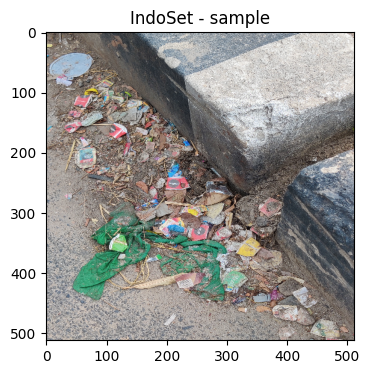

In [5]:
india_data_path = r"/kaggle/working/Dgen-VES"

def sample_indoset():
    rn = random.randint(0, len(os.listdir(india_data_path)))
    sample_img_path = os.path.join(india_data_path, os.listdir(india_data_path)[rn])
    sample_img_indo = cv2.imread(sample_img_path)
    sample_img_indo = cv2.cvtColor(sample_img_indo, cv2.COLOR_RGB2BGR)
    sample_img_indo = cv2.resize(sample_img_indo, (512, 512))
    return sample_img_indo

sample_img_indo = sample_indoset()
fig = plt.figure(figsize = (4, 4))
plt.imshow(sample_img_indo)
plt.title('IndoSet - sample')

plt.show()

----

### Segementation Module | Seg-VSE

---

In [ ]:
import importlib
importlib.reload(dmp)

time-taken for data-loading:  0.20936623016993205 mins
Samples-Size:  (100, 512, 512, 3) Mask-Size:  (100, 512, 512)



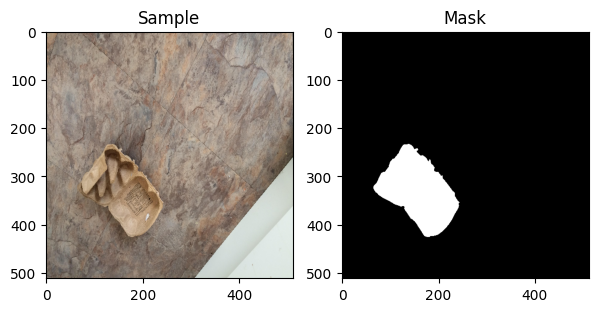

In [6]:
import data_mask_pipeline as dmp

num_samples = 100

ft = time.time()
dsp = dmp.data_segment_pipeline(num_samples = num_samples)
samples, masks = dsp.seg_visx()
lt = time.time()

# ft = time.time()
# dsp = dmp.data_segment_pipeline(num_samples = num_samples)
# samples, masks, sample_mask = dsp.seg_visx()
# lt = time.time()

print('time-taken for data-loading: ', (lt - ft) / 60, 'mins')
print('Samples-Size: ', samples.shape, 'Mask-Size: ', masks.shape)
print()

fig, axs = plt.subplots(1, 2, figsize = (7, 7))

rn = random.randint(0, num_samples - 1)

axs[0].imshow(samples[rn])
axs[0].set_title('Sample')

axs[1].imshow(masks[rn], cmap = 'gray')
axs[1].set_title('Mask')

plt.show()

Hugginface-Instance Prediction

In [ ]:
!pip -q install -U transformers accelerate

In [ ]:
import requests
import torch
from PIL import Image
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
import sys

# load Mask2Former fine-tuned on COCO panoptic segmentation

# processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-instance")
# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-coco-instance")

processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")


# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
image = Image.fromarray(samples[rn])

# print(type(image), image.size)
# plt.imshow(image)
# plt.show()

# sys.exit()

inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to processor for postprocessing
result = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
# we refer to the demo notebooks for visualization (see "Resources" section in the Mask2Former docs)
predicted_panoptic_map = result["segmentation"]

fig, axs = plt.subplots(1, 2, figsize = (7, 7))

axs[0].imshow(image)
axs[0].set_title('Image')

axs[1].imshow(predicted_panoptic_map)
axs[1].set_title('Panoptic Map')

plt.show()

#### Data-Augmentation

time-taken for data-augmentation:  0.16457815965016684  mins
(500, 512, 512, 3) (600, 512, 512, 3) (500, 512, 512) (600, 512, 512)


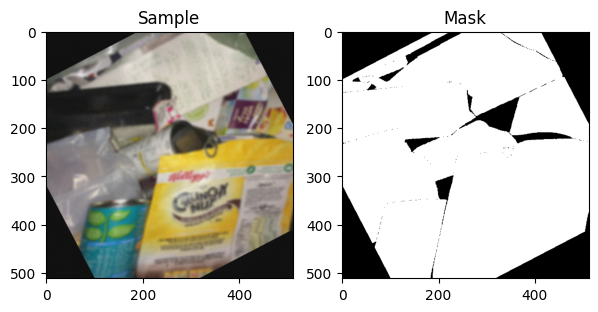

80

In [7]:
def activator_masks(images, augmenter, parents, default):
    if augmenter.name in ["Blur", "AWGN", "Add","Multiply"]:
        return False
    else:
        return default

def data_aug_pipeline(samples, masks, n_aug = 5):
    
    samples_aug, masks_aug = [], []
    
    for sample_image, sample_mask in zip(samples, masks):
    
        seq = iaa.Sequential([
            iaa.AdditiveGaussianNoise(scale=0.01 * 255, name="AWGN"),
            iaa.GaussianBlur(sigma=(0.0, 3.0), name="Blur"),
            iaa.Fliplr(0.5),
            iaa.Add((-20, 20),name="Add"),
            iaa.Multiply((0.8, 1.2), name="Multiply"),
            iaa.Affine(rotate=(-45, 45)),  # rotate by -45 to 45 degrees
        ], random_order=True)

        hooks_masks = ia.HooksImages(activator=activator_masks)

        for i in range(n_aug):

            seq_det = seq.to_deterministic()
            image_augmented = seq_det.augment_image(sample_image)
            mask_augmented = seq_det.augment_image(sample_mask.astype(np.uint8), hooks=hooks_masks)

            samples_aug.append(image_augmented)
            masks_aug.append(mask_augmented)
    
    return np.array(samples_aug), np.array(masks_aug)

ft = time.time()
aug_samples, aug_masks = data_aug_pipeline(samples, masks)
lt = time.time()

print('time-taken for data-augmentation: ', (lt - ft)/60, ' mins')

samples_all = np.concatenate((samples, aug_samples))
masks_all = np.concatenate((masks, aug_masks))

shuffle_order = np.random.permutation(len(samples_all))

samples_all, masks_all = samples_all[shuffle_order], masks_all[shuffle_order]

print(aug_samples.shape, samples_all.shape, aug_masks.shape, masks_all.shape)

fig, axs = plt.subplots(1, 2, figsize = (7, 7))

rn = random.randint(0, num_samples)

axs[0].imshow(samples_all[rn])
axs[0].set_title('Sample')

axs[1].imshow(masks_all[rn], cmap = 'gray')
axs[1].set_title('Mask')

plt.show()

del samples
del masks
del aug_samples
del aug_masks

gc.collect()

### Masked-Segmentation | UNET
BBox Anchoring is needed

In [8]:
!pip -q install torchsummary

DataSet - Creator | execute at once

In [9]:
class SegDataset(Dataset):
    def __init__(self, samples, masks):
        self.samples = samples
        self.masks = masks
        
#         mean, std = 0.5, 0.5
#         mean, std = 0.45, 0.23

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

#         mean = [np.mean(samples[:, :, 0])/255, np.mean(samples[:, :, 1])/255, np.mean(samples[:, :, 2])/255]
#         std = [np.std(samples[:, :, 0])/255, np.std(samples[:, :, 1])/255, np.std(samples[:, :, 2])/255]
        
        print('sample-mean: ', mean, ', std: ', std)
        
        ## Wrong Normalization??
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        mask = self.masks[idx]
        sample = self.transform(sample).float() 
        
#         mask = np.expand_dims(mask, axis = -1)
        mask = torch.from_numpy(mask)
    
        ## for direct-logits scaler
        mask = torch.nn.functional.one_hot(mask.long(), num_classes=num_classes)
        
        return sample, mask

train_num, test_num = 0.85, 0.15 
train_samples, train_masks = samples_all[:int(train_num * len(samples_all))], masks_all[:int(train_num * len(samples_all))]   
test_samples, test_masks = samples_all[int(train_num * len(samples_all)) + 1:], masks_all[int(train_num * len(samples_all)) + 1:]

train_dataset = SegDataset(train_samples, train_masks)
test_dataset = SegDataset(test_samples, test_masks)

print('Train-size: ', len(train_dataset))

train_dataloader = DataLoader(train_dataset, batch_size = 4, shuffle = True)

sample-mean:  [0.485, 0.456, 0.406] , std:  [0.229, 0.224, 0.225]
sample-mean:  [0.485, 0.456, 0.406] , std:  [0.229, 0.224, 0.225]
Train-size:  510


In [10]:
from torchsummary import summary
from unet_vanilla import SegmentationUNET

img_size = (3, 512, 512)
num_classes = 2
model = SegmentationUNET(img_size, num_classes).to(device)

# print(model)
summary(model, input_size = img_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1          [-1, 3, 512, 512]         262,656
            Conv2d-2         [-1, 32, 256, 256]             896
       BatchNorm2d-3         [-1, 32, 256, 256]              64
              ReLU-4         [-1, 32, 256, 256]               0
            Conv2d-5         [-1, 64, 128, 128]           2,112
            Conv2d-6         [-1, 64, 256, 256]          18,496
       BatchNorm2d-7         [-1, 64, 256, 256]             128
              ReLU-8         [-1, 64, 256, 256]               0
         MaxPool2d-9         [-1, 64, 128, 128]               0
     EncoderBlock-10  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
           Conv2d-11          [-1, 128, 64, 64]           8,320
           Conv2d-12        [-1, 128, 128, 128]          73,856
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14    

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epoch = 5
losses = []

ft = time.time()
for epoch in range(num_epoch):   
    for samples, masks in train_dataloader:
        
        optimizer.zero_grad()        
#         print(samples.dtype, masks.dtype, samples.shape, masks.shape)
        
        samples = samples.to(device)
        masks = masks.to(device)
        
        outputs = model(samples)
        outputs = outputs.permute(0, 2, 3, 1)
        loss = criterion(outputs, masks.float())
                    
        loss.backward()
        optimizer.step()
        
    print(f'Epoch - {epoch + 1}/{num_epoch} - Loss: {loss.item():.4f}')
    losses.append(loss.item())
    
lt = time.time()
print('time-taken for training: ', (lt - ft) / 60, ' mins')

In [ ]:
epoch_list = np.arange(0, num_epoch, 1)

fig = plt.figure(figsize = (4, 4))

plt.plot(epoch_list, losses, color = 'red', marker = '.')
plt.title('train-loss')
plt.show()

### Prediction - TACO

In [11]:
model_weights_path = r"/kaggle/input/models-v1/u_net_ep-60-model_weights.pt"
model.load_state_dict(torch.load(model_weights_path))

<All keys matched successfully>

torch.Size([1, 3, 512, 512]) (512, 512)
torch.Size([1, 3, 512, 512]) (512, 512) (512, 512)


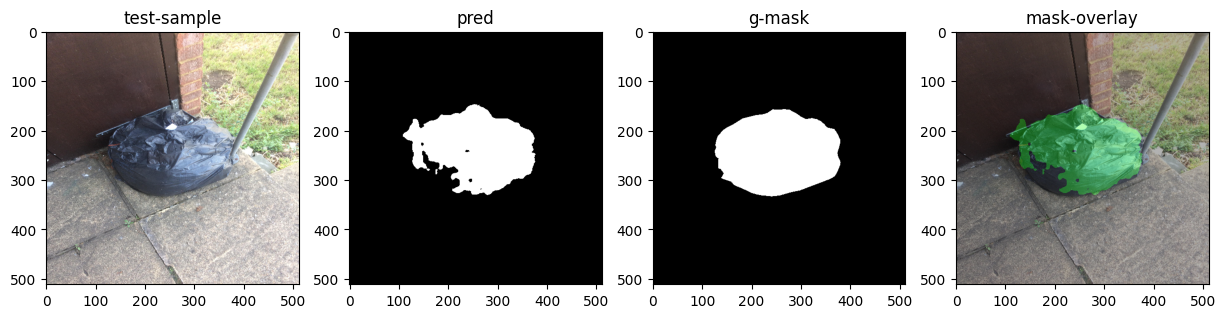

In [15]:
mean = [np.mean(test_samples[:, :, 0])/255, np.mean(test_samples[:, :, 1])/255, np.mean(test_samples[:, :, 2])/255]
std = [np.std(test_samples[:, :, 0])/255, np.std(test_samples[:, :, 1])/255, np.std(test_samples[:, :, 2])/255]
        
# mean, std = 0.5, 0.5
# mean, std = 0, 1
# mean, std = 62, 69
alpha = 0.7
beta = 1- alpha

''' Test-Dataset '''
# rn_test = random.randint(0, len(test_dataset))
# one_test_sample_input, one_test_mask = test_dataset[rn_test] ## Normalized Data
# one_test_mask = one_test_mask.argmax(-1).cpu().numpy()
# one_test_sample_input = one_test_sample_input.unsqueeze(0)

''' Test-Sampling - Direct '''
rn_test = random.randint(0, len(test_samples))
one_test_sample, one_test_mask = test_samples[rn_test], test_masks[rn_test]
one_test_sample_input = one_test_sample.copy()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
one_test_sample_input = transform(one_test_sample_input).unsqueeze(0)

print(one_test_sample_input.size(), one_test_mask.shape)

one_test_sample_input = one_test_sample_input.to(device)

model.eval()
pred = model(one_test_sample_input).permute(0, 2, 3, 1).argmax(-1).cpu().permute(1, 2, 0).numpy()
pred = np.squeeze(pred)

# one_test_sample_input = one_test_sample_input.cpu()[0].permute(1, 2, 0).numpy()
# one_test_sample_input = -((one_test_sample_input * std) + mean)

print(one_test_sample_input.shape, pred.shape, one_test_mask.shape)

color_mask = np.zeros_like(one_test_sample)
color_mask[pred == 1] = (0, 255, 0)
color_mask_img = cv2.addWeighted(one_test_sample, alpha, color_mask, beta, 0)

fig, axs = plt.subplots(1, 4, figsize = (15, 15))

axs[0].imshow(one_test_sample)
axs[0].set_title('test-sample')

axs[1].imshow(pred, cmap = 'gray')
axs[1].set_title('pred')

axs[2].imshow(one_test_mask, cmap = 'gray')
axs[2].set_title('g-mask')

axs[3].imshow(color_mask_img)
axs[3].set_title('mask-overlay')

plt.show()

### Prediction - IndoSet

(512, 512, 3) (512, 512) (512, 512, 3)


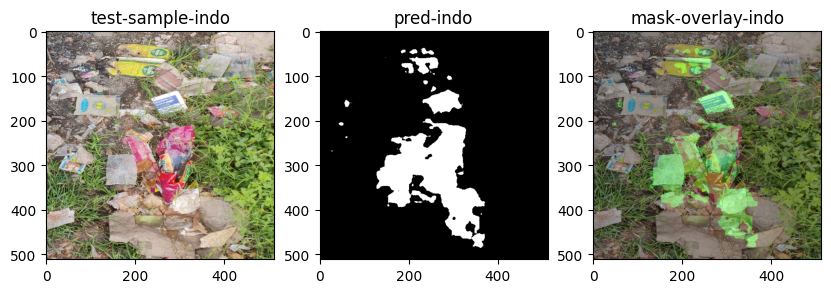

In [16]:
alpha = 0.7
beta = 1 - alpha
# mean = 0.5
# std = 0.5

sample_img_indo = sample_indoset()

sample_img_indo_input = sample_img_indo.copy()

mean = [np.mean(test_samples[:, :, 0])/255, np.mean(test_samples[:, :, 1])/255, np.mean(test_samples[:, :, 2])/255]
std = [np.std(test_samples[:, :, 0])/255, np.std(test_samples[:, :, 1])/255, np.std(test_samples[:, :, 2])/255]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

sample_img_indo_input = transform(sample_img_indo_input).unsqueeze(0)
sample_img_indo_input = sample_img_indo_input.to(device)
# print(sample_img_indo_input.size())

model.eval()
pred_indo = model(sample_img_indo_input.float()).permute(0, 2, 3, 1).argmax(-1).cpu().permute(1, 2, 0).numpy()
pred_indo = np.squeeze(pred_indo)

color_mask_indo = np.zeros_like(sample_img_indo)
color_mask_indo[pred_indo == 1] = (0, 255, 0)

color_mask_img_indo = cv2.addWeighted(sample_img_indo, alpha, color_mask_indo, beta, 0)

print(sample_img_indo.shape, pred_indo.shape, color_mask_img_indo.shape)

fig, axs = plt.subplots(1, 3, figsize = (10, 10))

axs[0].imshow(sample_img_indo)
axs[0].set_title('test-sample-indo')

axs[1].imshow(pred_indo, cmap = 'gray')
axs[1].set_title('pred-indo')

axs[2].imshow(color_mask_img_indo)
axs[2].set_title('mask-overlay-indo')

plt.show()

In [ ]:
model_state_dict = model.state_dict()
torch.save(model_state_dict, 'u_net_ep-20-model_weights.pt')

# model.load_state_dict(torch.load('u_net_ep-60-model_weights.pt'))

In [ ]:
# one_test_sample, _ = test_dataset[rn_test]

# sample = one_test_sample.permute(1, 2, 0)

# mean = 0.5
# std = 0.5

# # Denormalize your data
# sample = (sample * std) + mean

# plt.imshow(sample)
# plt.title('test-sample')

# plt.show()

### DeepLabV3+ | Binary Segmenation

In [6]:
!pip -q install torchsummary

In [ ]:
# from torchvision import ops
# import torchvision.models as models

In [9]:
from torchsummary import summary
from deeplabv3 import Deeplabv3 as dp3

img_size = (3, 512, 512)
num_classes = 2
model = dp3(num_classes = num_classes, image_size=img_size).to(device)

summary(model, input_size = img_size)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 146MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1          [-1, 3, 512, 512]         262,656
            Conv2d-2         [-1, 64, 256, 256]           9,408
       BatchNorm2d-3         [-1, 64, 256, 256]             128
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6         [-1, 64, 128, 128]           4,096
       BatchNorm2d-7         [-1, 64, 128, 128]             128
              ReLU-8         [-1, 64, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]          36,864
      BatchNorm2d-10         [-1, 64, 128, 128]             128
             ReLU-11         [-1, 64, 128, 128]               0
           Conv2d-12        [-1, 256, 128, 128]          16,384
      BatchNorm2d-13        [-1, 256, 128, 128]             512
           Conv2d-14        [-1, 256, 1

In [ ]:
class conv_block(nn.Module):
    
    def __init__(self, out_channel=256, kernel_size=3, dilation_rate=1, use_bias=False):
        super().__init__()
        self.out_channel = out_channel
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.use_bias = use_bias
        self.b_norm = nn.BatchNorm2d(self.out_channel).to(device)
        self.relu = nn.ReLU(inplace = True).to(device)
        
    def forward(self, block_input):
        in_channel = in_channel = block_input.size()[1]
        x = nn.Conv2d(in_channels = in_channel, out_channels = self.out_channel, kernel_size = self.kernel_size, dilation = self.dilation_rate, bias = self.use_bias, padding = 'same', device = device)(block_input)
        x = self.b_norm(x)
        x = self.relu(x)
        return x

class DilatedConv(nn.Module):
    def __init__(self, 
                conv_meta = {'kernel_size' : [1, 3, 3, 3],
                             'dilations' : [1, 6, 12, 18]}):
        super().__init__()
        self.conv_meta = conv_meta
        self.avg_pool = nn.AvgPool2d(kernel_size = 3, stride = 2, padding = 1).to(device)
        self.conv_block_1 = conv_block(kernel_size = 1, use_bias = True).to(device)
        self.conv_block_2 = conv_block(kernel_size = 1).to(device)
        
    def forward(self, dspp_input):
        
    #     dims = dspp_input.size()
    #     x = nn.AvgPool2d(kernel_size = (dims[-2], dims[-1]))(dspp_input)
        x = self.avg_pool(dspp_input)
        x = self.conv_block_1(x)
        out_pool = nn.functional.interpolate(x, scale_factor = 2, mode = 'bilinear').to(device)
    #     out_pool = nn.functional.interpolate(x, size = (dims[-2] // x.size(2), dims[-1] // x.size(3)), mode = 'bilinear')

        ## Multi-Scale Convolution to capture diff range of features
        outs = [out_pool]
        for i in range(len(self.conv_meta['dilations']) - 2):
            temp_cb = conv_block(kernel_size = self.conv_meta['kernel_size'][i], dilation_rate = self.conv_meta['dilations'][i])
            outs.append(temp_cb(dspp_input))

    #     x = torch.cat([out_pool, out_1, out_6], dim = 1)
        x = torch.cat(outs, dim = 1)
        output = self.conv_block_2(x)
        return output

class Deeplabv3(nn.Module):
    def __init__(self, image_size, num_classes):
        super().__init__()
        
        self.image_size = image_size
        self.num_classes = num_classes
        
        self.input_layer = nn.Linear(in_features = image_size[1], out_features = image_size[1])
        self.resnet50 = models.resnet50(pretrained=True)
        
        self.dilated_conv = DilatedConv().to(device)
        
        self.entry_block = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.end_block = nn.ModuleList([
            conv_block(out_channel = 256, kernel_size = 1, use_bias = True),
            conv_block(out_channel = 128, kernel_size = 1, use_bias = True)
        ]) 
        
        self.conv_block_1 = conv_block(out_channel = 48, kernel_size = 1).to(device)
        self.conv_block_2 = conv_block(out_channel = 256).to(device)
        
        self.final_conv = nn.Conv2d(128, num_classes, kernel_size=1, padding='same')
        
    def forward(self, x, inference = False):  
        
        x = self.input_layer(x)
        
#         x = self.entry_block(x)
        
        x = self.resnet50.conv1(x)
        x = self.resnet50.bn1(x)
        x = self.resnet50.relu(x)
        x = self.resnet50.maxpool(x)
        
        x1 = self.resnet50.layer1(x)
        x2 = self.resnet50.layer2(x1)
        x3 = self.resnet50.layer3(x2)
#         x4 = self.resnet50.layer4(x)
        
        input_a = self.dilated_conv(x3)
        
#         input_a = nn.functional.interpolate(input_a, size = (2 * self.image_size[-1] // input_a.size(2), 2 * self.image_size[-1] // input_a.size(3)), mode = 'bilinear', align_corners=True)
        input_a = nn.functional.interpolate(input_a, size = (x2.size(2), x2.size(3)), mode = 'bilinear', align_corners=True)
        input_b = self.conv_block_1(x2)
        x = torch.cat([input_a, input_b], dim = 1)
        
        x = self.conv_block_2(x)
        x = self.conv_block_2(x)
        
#         x = nn.functional.interpolate(x, size=(self.image_size[-1] // x.size(2), self.image_size[-1] // x.size(2)), mode = 'bilinear', align_corners=True)
        for end_block in self.end_block:
            x = end_block(x)
        x = nn.functional.interpolate(x, size=(self.image_size[-1], self.image_size[-1]), mode = 'bilinear', align_corners=True)
        x = self.final_conv(x)
        
        if inference:
            x = torch.sigmoid(x)
        
        return x
     
num_classes = 2
image_size = (3, 512, 512)
model = Deeplabv3(num_classes = num_classes, image_size=image_size).to(device)
summary(model, input_size = image_size)

In [ ]:
import sys
# !pip -q install apex
# import apex
# from apex import amp

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# model, optimizer = amp.initialize(model, optimizer, opt_level = 'O1')


num_epoch = 2
losses = []

ft = time.time()
for epoch in range(num_epoch):   
    for samples, masks in train_dataloader:
        
        optimizer.zero_grad()        
            
        samples = samples.to(device)
        masks = masks.to(device).float()
        
        outputs = model(samples)
        outputs = outputs.permute(0, 2, 3, 1)
        
        loss = loss_fn(outputs, masks)
        
#         with amp.scale_loss(loss_fn(outputs, masks), optimizer) as scaled_loss:
#             scaled_loss.backward()
        
        loss.backward()
        optimizer.step()
        
    print(f'Epoch - {epoch + 1}/{num_epoch} - Loss: {loss.item():.4f}')
    losses.append(loss.item())
    
lt = time.time()
print('time-taken for training: ', (lt - ft) / 60, ' mins')

In [ ]:
epoch_list = np.arange(0, num_epoch, 1)

fig = plt.figure(figsize = (4, 4))

plt.plot(epoch_list, losses, color = 'red', marker = '.')
plt.title('train-loss')
plt.show()

### Prediction - TACO

In [ ]:
# mean = [np.mean(test_samples[:, :, 0])/255, np.mean(test_samples[:, :, 1])/255, np.mean(test_samples[:, :, 2])/255]
# std = [np.std(test_samples[:, :, 0])/255, np.std(test_samples[:, :, 1])/255, np.std(test_samples[:, :, 2])/255]
        
# mean, std = 0.5, 0.5
# mean, std = 0, 1

# mean, std = 0.45, 0.23

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# mean, std = 62, 69

alpha = 0.7
beta = 1- alpha

''' Test-Dataset '''
# rn_test = random.randint(0, len(test_dataset))
# one_test_sample_input, one_test_mask = test_dataset[rn_test] ## Normalized Data
# one_test_mask = one_test_mask.argmax(-1).cpu().numpy()
# one_test_sample_input = one_test_sample_input.unsqueeze(0)

''' Test-Sampling - Direct '''
rn_test = random.randint(0, len(test_samples))
one_test_sample, one_test_mask = test_samples[rn_test], test_masks[rn_test]
one_test_sample_input = one_test_sample.copy()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

one_test_sample_input = transform(one_test_sample_input).unsqueeze(0)
print(one_test_sample_input.size(), one_test_mask.shape)
one_test_sample_input = one_test_sample_input.to(device)

model.eval()
pred = model(one_test_sample_input).permute(0, 2, 3, 1).argmax(-1).cpu().permute(1, 2, 0).numpy()
pred = np.squeeze(pred)

# one_test_sample_input = one_test_sample_input.cpu()[0].permute(1, 2, 0).numpy()
# one_test_sample_input = -((one_test_sample_input * std) + mean)

print(one_test_sample_input.shape, pred.shape, one_test_mask.shape)

color_mask = np.zeros_like(one_test_sample)
color_mask[pred == 1] = (0, 255, 0)
color_mask_img = cv2.addWeighted(one_test_sample, alpha, color_mask, beta, 0)

fig, axs = plt.subplots(1, 4, figsize = (15, 15))

axs[0].imshow(one_test_sample)
axs[0].set_title('test-sample')

axs[1].imshow(pred, cmap = 'gray')
axs[1].set_title('pred')

axs[2].imshow(one_test_mask, cmap = 'gray')
axs[2].set_title('g-mask')

axs[3].imshow(color_mask_img)
axs[3].set_title('mask-overlay')

plt.show()

lt_ntbk = time.time()

# print('time-taken to run the ntbk: ', (lt_ntbk - ft_ntbk) / 60, ' mins')

In [ ]:
model.eval()
pred = model(one_test_sample_input, inference = True).permute(0, 2, 3, 1).cpu().detach().numpy()
pred = np.squeeze(pred)
print(pred.shape)

threshold = 0.5  # You can adjust this value based on your requirements
binary_mask = np.where(pred > threshold, 1, 0)
print(binary_mask.shape)

fig, axs = plt.subplots(1, 2, figsize = (7, 7))

axs[0].imshow(pred, cmap = 'gray')
axs[0].set_title('pred')

axs[1].imshow(binary_mask, cmap = 'gray')
axs[1].set_title('binary-mask')

plt.show()

In [ ]:
# pred = model(one_test_sample_input, inference = True).permute(0, 2, 3, 1).cpu().detach().numpy()
# pred = np.squeeze(pred)

# pred